In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv("data_csv/by_country/total.csv")
countries = pd.read_csv("data_csv/by_country/total.csv").set_index("Nation").index.unique()

In [6]:
def total_confirmed_global():
    global df
    df_time = df.copy()
    df_time["Time"] = pd.to_datetime(df_time["Time"])
    gb = df_time.groupby("Time")
    t = []
    c = []
    d = []
    r = []
    for i, frame in gb:
        t.append(i.strftime("%b-%d"))
        c.append(np.sum(frame["Confirmed Case"]))
        d.append(np.sum(frame["Death"]))
        r.append(np.sum(frame["Recover"]))
    df_total = pd.DataFrame({"Time":t, "Confirmed Case":c, "Death":d, "Recover":r})
    
    fig = plt.figure()
    plt.plot(df_total["Time"], df_total["Confirmed Case"], linewidth=5, c='r')
    plt.plot(df_total["Time"], df_total["Death"], linewidth=5, c='#4A4A4A')
    plt.plot(df_total["Time"], df_total["Recover"], linewidth=5, c='#3ad800')
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("Number of Cases", fontsize=18)
    plt.title("Global Cumulative Cases", fontsize=18)
    plt.tight_layout()
    fig.set_figheight(9)
    fig.set_figwidth(12)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
    plt.gca().tick_params(axis="x", labelsize=18)
    plt.gca().tick_params(axis="y", labelsize=18)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xticks(rotation=45)
    plt.grid(b=1, which="major", axis="both", c='#C0C0C0')
    plt.legend()
    plt.savefig("results/total.png")
#     plt.close(fig)

In [40]:
def confirmed_cases_plot(df):
    fig = plt.figure()
    plt.plot(pd.to_datetime(df["Time"]).dt.strftime("%b-%d"),df["Confirmed Case"], linewidth=5, c='r')
    plt.xlabel("Time", fontsize=18)
    plt.ylabel("Number of Cases", fontsize=18)
    plt.title("{} Coronavirus Count".format(country), fontsize=18)
    plt.tight_layout()
    fig.set_figheight(9)
    fig.set_figwidth(12)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
    plt.gca().tick_params(axis="x", labelsize=18)
    plt.gca().tick_params(axis="y", labelsize=18)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xticks(rotation=45)
    plt.grid(b=1, which="major", axis="both", c='#C0C0C0')
    plt.savefig("results/confirmed_cases_{}.png".format(country))
    plt.close(fig)

In [135]:
for country in countries:
    df_x = pd.read_csv("data_csv/by_country/{}.csv".format(country))
    confirmed_cases_plot(df_x)

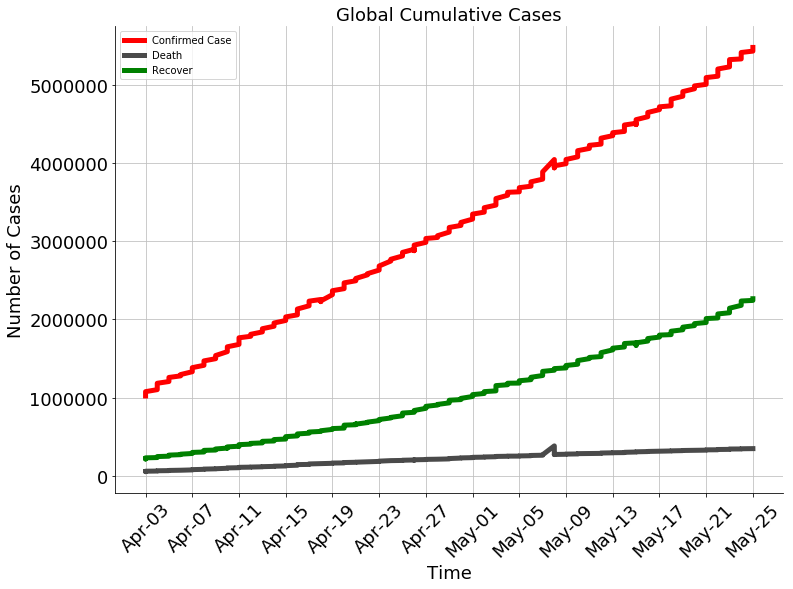

In [7]:
total_confirmed_global()